In [1]:
from collections import Counter
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 20)

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
from statistic import Statistic
from utils import UtilsKy
from analyzer import HelperAnalyzer, AnalyzerPrediction

In [5]:
# for autoreload modules
%load_ext autoreload
%autoreload 2

In [6]:
# kyw3
#path_data = '/mnt/files/workdata/work/merchants/merchant_33_kyw3_2020-06-05/04_experiments/ex_01_some_teach/'
db_teach = pd.read_csv(UtilsKy.DB_TEACH_KYW3, dtype=str, encoding='cp1251')
db_test = pd.read_csv(UtilsKy.DB_TEST_KYW3, dtype=str, encoding='cp1251')
white = pd.read_csv(UtilsKy.WHITE_KYW3 , dtype=str)

In [7]:
COL_FACTORS = ['bin', 'amount', 'bank_currency', 'hour', 'day_of_week', 'longitude', 
               'latitude', 'phone_2_norm', 'is_gender_undefined', 'is_city_resolved']
COL_FACTORS = sorted(COL_FACTORS)

In [8]:
# Prepare data for Xgboost
from helper import DataHelper
datahelper = DataHelper(db_teach, db_test, COL_FACTORS)
datahelper.create_train_test()
datahelper.show_columns_with_na()
mean_values = datahelper.get_mean_value()
replaced_values = { col: mean_values[col] for col in ('latitude', 'longitude')}
replaced_values['default'] =  -999
datahelper.replaced_na_values(replaced_values)   
train_db, test_db = datahelper.get_train_test()

train na columns : Index(['latitude', 'longitude'], dtype='object')
test na columns : Index(['latitude', 'longitude'], dtype='object')
-999
-999
-999
-999
36.90237577890762
-999
-92.53325861542274
-999
-999
-999


In [9]:
from typing import Tuple
# https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
def custom_metric_p5(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Percent bad in sample.'''
    sample_percent = 5
    label = dtrain.get_label()
    
    q_percent = np.quantile(predt, 1-sample_percent/100, axis=0)
    label_p = np.where(predt >= q_percent , label, 0)
   
    n_bad = label.sum()
    n_bad_sample = label_p.sum()
    p_bad_sample = n_bad_sample/n_bad
    
    print('custom_metric_p5={}, n_test={} '. format(p_bad_sample, len(label) ))
    return 'custom_metric_p5', -p_bad_sample


In [10]:
# https://docs.ray.io/en/master/xgboost-ray.html ~ doesn't work
# https://docs.ray.io/en/master/tune/tutorials/tune-xgboost.html
import sklearn.metrics
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback


def train_xgb_custom_metric(config: dict):

    is_validate_train_datasets = False
    
    if is_validate_train_datasets:
        train_x, validate_x, train_y, validate_y = train_db, test_db, db_teach.status, db_test.status
    else:
        train_x, validate_x, train_y, validate_y = train_test_split(train_db, db_teach.status, test_size=0.25)
    
    # Build input matrices for XGBoost
    train_set = xgb.DMatrix(train_x, label=train_y)
    validate_set = xgb.DMatrix(validate_x, label=validate_y)
    
    
    xgb.train(
        config,
        train_set,
        feval=custom_metric_p5,  
        evals=[(validate_set, "eval")],
        verbose_eval=False,
        callbacks=[TuneReportCheckpointCallback( filename="model.xgb")]
    )

In [21]:
def main():
    search_space = {
        # You can mix constants with search space objects.
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
        "max_depth": tune.randint(1, 9),
        "min_child_weight": tune.choice([1, 2, 3]),
        "subsample": tune.uniform(0.5, 1.0),
        "eta": tune.loguniform(1e-4, 1e-1)
    }
    # This will enable aggressive early stopping of bad trials.
    scheduler = ASHAScheduler(
        max_t=10,  # 10 training iterations
        grace_period=1,
        reduction_factor=2)

    analysis = tune.run(
        train_xgb_custom_metric,
        metric="eval-logloss",
        mode="min",
        # You can add "gpu": 0.1 to allocate GPUs
        resources_per_trial={"cpu": 1},
        config=search_space,
        num_samples=10,
        scheduler=scheduler)
        

    # Load the best model checkpoint
    best_bst = xgb.Booster()
    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    
    accuracy = 1. - analysis.best_result["eval-error"]
    print(f"Best model parameters: {analysis.best_config}")
    print(f"Best model total accuracy: {accuracy:.4f}")
    return analysis

In [25]:
best_bst = xgb.Booster()
best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))

In [27]:
analysis.best_config

{'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error'],
 'max_depth': 6,
 'min_child_weight': 1,
 'subsample': 0.8650436568459605,
 'eta': 0.054274354654195216}

In [37]:
result_df_amount = None
analyzer_prediction = AnalyzerPrediction(db_teach, db_test)
weight = analyzer_prediction.get_xgb_weight()

In [108]:
config = {'objective': 'binary:logistic', 'eval_metric': ['logloss', 'error'], 'max_depth': 4, 'n_estimators': 73,
          'min_child_weight': 2, 'subsample': 0.9918071934772892, 'eta': 0.07907943724636177}

config['eval_metric'] = custom_metric_p5
model = xgb.XGBClassifier(**config)

model.fit(train_db, db_teach.status, 
          sample_weight=weight)

test_pred = model.predict_proba(test_db)
db_test["probability"] = test_pred[:, 1]

description = '-' . join([str(elem) for elem in (config['max_depth'], config['n_estimators'], round(config['eta'],3))])
description +=  '_' + str(config['eval_metric'])

result_df_amount = analyzer_prediction.get_table_prediction(description=description, result_df=result_df_amount, metric="count")

/home/sergey/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [109]:
result_df_amount

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,...,n_test_in_wl,n_test_bad_in_wl,amount_test_in_wl,amount_test_bad_in_wl,n_teach,n_teach_bad,n_test,n_test_bad,amount_test_bad,amount_test
0,"4-73-0.079_['logloss', 'error']",5.700000,8.480000,12.320000,15.230000,17.750000,19.60000,22.380000,29.010000,45.170000,...,0,0,0,0,433425,6261,58862,755,120400.38,4.989361e+06
1,threshold count,0.729683,0.695354,0.674476,0.661393,0.650177,0.63946,0.630397,0.607124,0.554434,...,0,0,0,0,433425,6261,58862,755,120400.38,4.989361e+06
2,4-73-0.079_<function rmsle2 at 0x7f7ea85d5f80>,5.700000,8.480000,12.320000,15.230000,17.750000,19.60000,22.380000,29.010000,45.170000,...,0,0,0,0,433425,6261,58862,755,120400.38,4.989361e+06
3,threshold count,0.729683,0.695354,0.674476,0.661393,0.650177,0.63946,0.630397,0.607124,0.554434,...,0,0,0,0,433425,6261,58862,755,120400.38,4.989361e+06


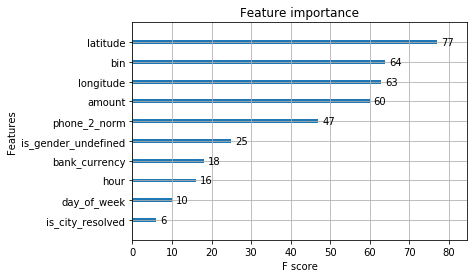

In [43]:
xgb.plot_importance(bst)

In [41]:
bst.feature_names

['amount',
 'bank_currency',
 'bin',
 'day_of_week',
 'hour',
 'is_city_resolved',
 'is_gender_undefined',
 'latitude',
 'longitude',
 'phone_2_norm']

In [215]:
bst.get_fscore()

{'amount': 36,
 'bin': 34,
 'latitude': 18,
 'bank_currency': 5,
 'phone_2_norm': 20,
 'longitude': 16,
 'is_gender_undefined': 9}

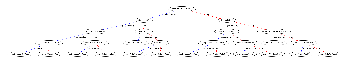

In [201]:
xgb.plot_tree(bst, num_trees=2)

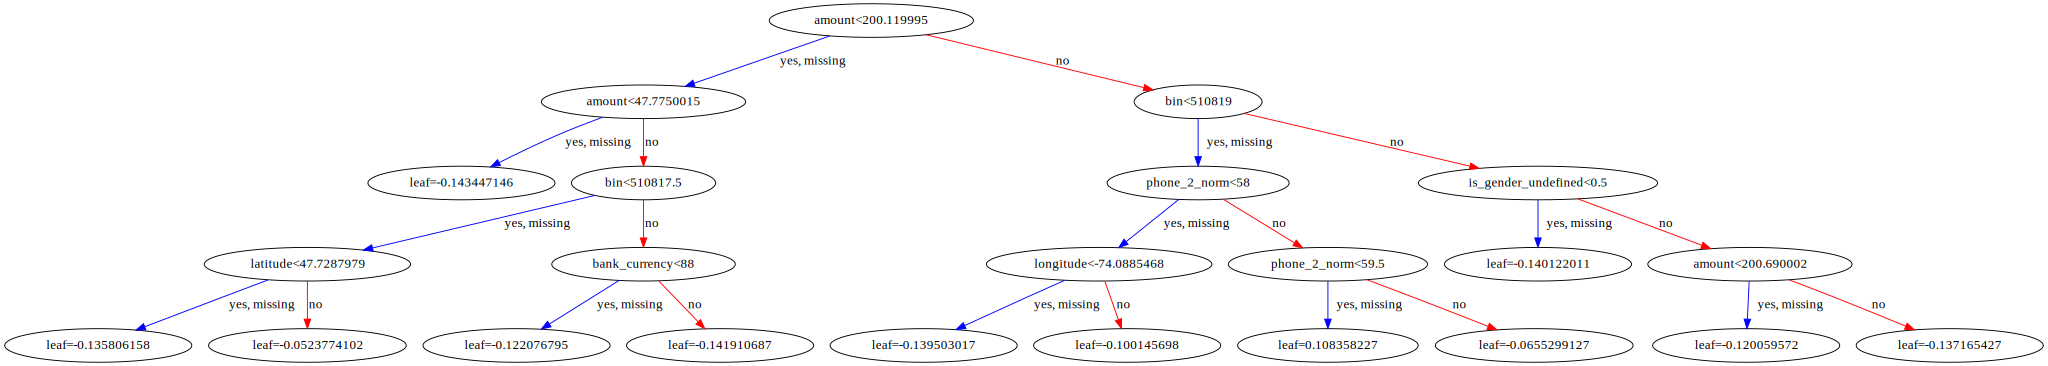

In [212]:
xgb.to_graphviz(bst, num_trees=1)

In [194]:
n = result_df_amount.shape[0]
sub_rows = list(range(n))[::2]
stat_best = result_df_amount.copy().iloc[sub_rows,:]

col_names = [col for col in stat_best.columns if col.startswith('p_') ] 
stat_best.loc[:, col_names] = stat_best.loc[:, col_names].astype(float)
stat_best = stat_best.sort_values(by="rating", ascending=False)

In [195]:
stat_best.iloc[:, :11]

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,rating
8,4-73-0.079booster,6.36,11.39,14.97,18.28,20.40,23.31,27.15,34.04,45.56,151.00
6,4-73-0.079booster,6.49,11.92,13.77,17.09,20.66,23.84,27.15,33.77,46.62,150.32
10,4-73-0.079booster,5.96,11.79,13.91,18.15,20.66,22.38,24.64,31.92,45.03,147.42
32,4-73-0.079booster_21,6.09,11.13,14.44,16.56,19.34,23.97,26.09,34.44,45.30,147.30
30,4-73-0.079booster_21,6.09,11.13,14.44,16.56,19.34,23.97,26.09,34.44,45.30,147.30
14,4-73-0.079booster,5.70,10.46,14.57,17.09,21.32,24.11,26.75,33.38,44.64,147.16
16,4-73-0.079booster,5.56,8.87,14.83,17.48,20.00,23.05,27.42,34.30,45.30,146.34
12,4-73-0.079booster,5.17,7.02,10.46,16.29,20.66,24.50,27.42,33.91,48.48,141.99
20,4-73-0.079booster,4.37,7.68,10.46,15.76,20.13,23.05,26.62,34.44,48.08,140.92
4,4-73-0.079booster,6.36,10.86,12.32,15.36,18.54,21.99,25.17,30.99,44.64,139.07
